In [8]:
import torch
import torch.nn.init

device = None
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 랜덤 시드 고정
torch.cuda.manual_seed_all(777)

# 현재 디바이스가 무엇인지?
print('Current Device : ' + str(device))

Current Device : mps


In [9]:
import os
import torchvision.transforms as transforms # MNIST 데이터를 텐서 형태로 바꾸기 위해
import torchvision.datasets as dsets # 이 안에 MNIST 있다

if os.path.exists('MNIST'):
    print('There is MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=False)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=False)
    # train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, download=False)
    # test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, download=False)
else: # MNIST 데이터 다운로드
    print('There is no MNIST data.')
    train_raw = dsets.MNIST(root=str(os.getcwd()), train=True, transform=transforms.ToTensor(), download=True)
    test_raw = dsets.MNIST(root=str(os.getcwd()), train=False, transform=transforms.ToTensor(), download=True)

print(train_raw)
print(test_raw)

There is MNIST data.
Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/ljs/NODE
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/ljs/NODE
    Split: Test
    StandardTransform
Transform: ToTensor()


In [104]:
from torch.utils.data import Dataset

class Customdataset(Dataset):
    def __init__(self, dataset:dsets.MNIST, quantization_level = 10) -> None:
        self.origin_dataset = dataset
        self.quantization_level = quantization_level
        return None
    
    def quantize_tensor(self, tensor:torch.Tensor, levels:int) -> torch.Tensor:
        min_value = tensor.min()
        max_value = tensor.max()
        quantized_tensor = tensor.clone()
        quantized_tensor.sub_(min_value).div_(max_value - min_value + 1e-5).mul_(levels - 1).round_().div_(levels - 1).mul_(max_value - min_value + 1e-5).add_(min_value)
        return quantized_tensor

    def __len__(self):
        return len(self.x) # x 길이랑 y 길이랑 같음.

    def __getitem__(self, idx:int) -> tuple[torch.Tensor, torch.Tensor]:
        data, label = self.origin_dataset[idx]
        modified_data = self.quantize_tensor(data, self.quantization_level)
        return modified_data, label
        # return torch.from_numpy(self.x[idx]), torch.from_numpy(self.y[idx])

train_custom = Customdataset(train_raw, quantization_level=10)
test_custom = Customdataset(test_raw, quantization_level=10)


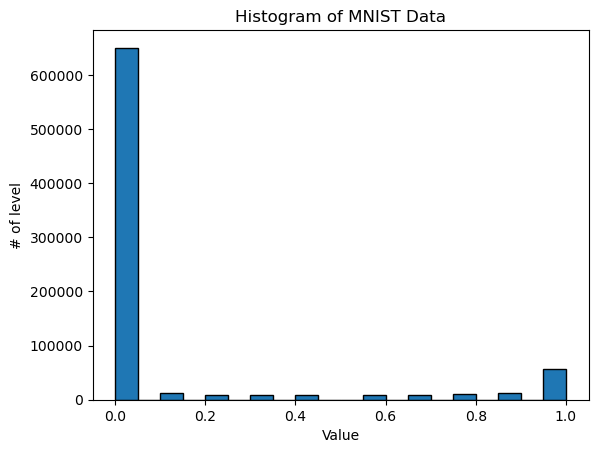

In [106]:
# 데이터에서 어떤 레벨의 값들이 많은지 확인
import numpy as np
import matplotlib.pyplot as plt

temp = np.zeros(1)
for idx, (data,label) in enumerate(test_custom):
    temp = np.append(temp, data.view(-1).numpy())
    if idx == 1000: break # 1000개만. 너무 많으면 동작 멈춰버리는듯?

plt.hist(temp, bins=20, edgecolor='black') # Plot the histogram with 20 bins and black edges
plt.title('Histogram of MNIST Data') # Add title to the plot
plt.xlabel('Value') # Label the x-axis
plt.ylabel('# of level') # Label the y-axis
plt.show() # Display the plot